#  MONAI Bootcamp
## End-To-End Workflow with MONAI part 2 ( Ignite for train script)


## Ignite 
MONAI support Ignite and pytorch lightning to help with training and evaluating neural networks in PyTorch flexibly

[Ignite](https://pytorch.org/ignite) is a high-level library to help with training and evaluating neural networks in PyTorch flexibly and transparently.

<img src="https://raw.githubusercontent.com/pytorch/ignite/master/assets/tldr/pytorch-ignite-teaser.gif" width=400>


[pytorch lightning](https://www.pytorchlightning.ai/) is the deep learning framework for professional AI researchers and machine learning engineers who need maximal flexibility without sacrificing performance at scale.

<img src="https://github.com/PyTorchLightning/pytorch-lightning/raw/master/docs/source/_static/images/general/pl_quick_start_full_compressed.gif" width=1024>



# same baseline End-to-end Training with Ignite
We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example. First, we're going to use the basic PyTorch paradigm for training our model. We'll then look at how to train using the Ignite workflows to make things even easier!

## baseline  End-to-End Training Workflow
To help guide you through training your first model using MONAI, this guide will will cover five key phases:

 1. Setting up our Dataset and exploring the data
 2. Preparing datasets and transforms
 3. Define your network and create our PyTorch training loop [replace with ignite]
 4. Evaluate your model and understand the results
 
Let's get started by importing our dependencies.

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

before start, check current GPU memory with `nvidia-smi`

In [2]:
!nvidia-smi 

Sat Nov  5 02:59:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:87:00.0 Off |                   On |
| N/A   34C    P0    61W / 400W |     39MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [3]:
import os 
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


Download the MedNIST dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and the [NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license. If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.
It will take about 1 minute

In [4]:
%%time

resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

CPU times: user 156 µs, sys: 82 µs, total: 238 µs
Wall time: 257 µs


### Set deterministic training for reproducibility

[`set_determinism`](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [5]:
set_determinism(seed=0)

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more. We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT. We'll be using each of these categories as our label names.

In [6]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"number of Labels: {num_class}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
number of Labels: 6
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# 2. Preparing datasets and transforms
### Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing. We'll use a ratio of 80/10/10 for those sets.

In [7]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 46946, Validation count: 6022, Test count: 5986


### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`. In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

In [8]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=num_class, n_classes=num_class)])

### Initialise the datasets and loaders for training, validation and test sets
- Define a simple dataset, that we'll call `MedNISTDataset`, that  groups:

 - Images
 - Labels
 - The transforms that are to be run on the images and labels
- Create three instances of this dataset:
  - One for training
  - One for validation
  - One for testing

We'll use a batch size of 512 and employ 10 workers to load the data.

In [9]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


3. Define your network and create our PyTorch training loop
Define network and optimizer
Set learning_rate for how much the model is updated per step
The fetch a pytorch device for the GPU
Instantiate a `densenet121` model instance and 'send' it to the GPU using device
This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
We'll make use of the Adam optimizer

In [10]:
# Configure 
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)


## Let's make some changes

Everything that we have done so far uses MONAI with pytorch in a very vanilla fashion. The initial training / validation loop is written to show you the nuts and bolts of pytorch. Now let's explore starting the move towards Ignite and features of MONAI designed to work with it.

### pytorch version 
Network training
We are hand-rolling a basic pytorch training loop here:

standard pytorch training loop
step through each training epoch, running through the training set in batches
after each epoch, run a validation pass, evaluating the network
if it shows improved performance, save out the model weights

### Ignite version 
training loops in a more Ignite 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/workflows.png" width=600>




In [11]:
# Configure 
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### import ignite module

In [12]:

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC


#### configure ignite supervised traner

In [13]:

step = 1
iter_losses=[]
batch_sizes=[]
epoch_loss_values = []
metric_values = []


# Training

# this trainer takes care of the training loop for us
trainer = create_supervised_trainer(net, optimizer, loss_function, device, False)

# calculate the number of steps per epoch up front
steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1



#### configure training iteration

In [14]:
# create a handler for recording the loss after each input. Improve upon our earlier example
# by also recording the batch size, so we can perform a weighted average for the overall average
# loss
@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    global step
    loss = engine.state.output
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    iter_losses.append(loss)
    batch_sizes.append(batch_len)
    print(f'epoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch}, training_loss = {loss:.4f}')    
    step += 1
 

#### configure validation iteration ( every epoch)

In [15]:
   
# Validation

def roc_auc_trans(x):
    return [act(i) for i in decollate_batch(x[0])], [to_onehot(i) for i in decollate_batch(x[1])]

val_metrics = {
    'accuracy': Accuracy(), 
    'rocauc': ROCAUC(output_transform=roc_auc_trans)
}
evaluator = create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True
)


# validation is run every n training epochs in response to the trainer completing
# an epoch. Here we use the decorator syntax to add a function that runs it to the
# EPOCH_COMPLETED event
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    global step
    evaluator.run(val_loader)

    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]
    
    # fetch and report the validation metrics
    acc = evaluator.state.metrics['accuracy']
    roc = evaluator.state.metrics['rocauc']
    metric_values.append(roc)
    print(f"evaluation for epoch {engine.state.epoch}, accuracy = {acc:.4f}, rocauc = {roc:.4f}")

    # reset step for the next epoch
    step = 1
    
# create a checkpoint handler to save the network weights based on the area under the ROC curve
# as before
def _score(_):
    return metric_values[-1]

#### define ignite handler

In [16]:
# create a model checkpointer to save the network
checkpoint_handler = ModelCheckpoint(root_dir, filename_prefix='mednist_model_best', score_name='',
                                     n_saved=1, require_empty=False, score_function=_score)

# handlers are attached to events in trainers and evaluators
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED,
                          handler=checkpoint_handler, to_save={'net': net})


 #### launch to train with ignite handler

In [17]:
%%time 
# train (and evaluate) the network, Ignite-style!
train_epochs = 4
state = trainer.run(train_loader, train_epochs)

best_rocauc = max(metric_values)
print(f"train completed, best_metric: {best_rocauc:.4f} at epoch: {metric_values.index(best_rocauc)}")

epoch 1/4, step 1/92, training_loss = 1.8205
epoch 1/4, step 2/92, training_loss = 1.8131
epoch 1/4, step 3/92, training_loss = 1.7762
epoch 1/4, step 4/92, training_loss = 1.7806
epoch 1/4, step 5/92, training_loss = 1.7447
epoch 1/4, step 6/92, training_loss = 1.7143
epoch 1/4, step 7/92, training_loss = 1.6714
epoch 1/4, step 8/92, training_loss = 1.6403
epoch 1/4, step 9/92, training_loss = 1.6156
epoch 1/4, step 10/92, training_loss = 1.5947
epoch 1/4, step 11/92, training_loss = 1.5956
epoch 1/4, step 12/92, training_loss = 1.5560
epoch 1/4, step 13/92, training_loss = 1.5335
epoch 1/4, step 14/92, training_loss = 1.5247
epoch 1/4, step 15/92, training_loss = 1.5000
epoch 1/4, step 16/92, training_loss = 1.5057
epoch 1/4, step 17/92, training_loss = 1.4657
epoch 1/4, step 18/92, training_loss = 1.4111
epoch 1/4, step 19/92, training_loss = 1.4354
epoch 1/4, step 20/92, training_loss = 1.4037
epoch 1/4, step 21/92, training_loss = 1.3897
epoch 1/4, step 22/92, training_loss = 1.33

### Plot the loss and metric
Once we're done training we want to visualize our Loss and Accuracy.

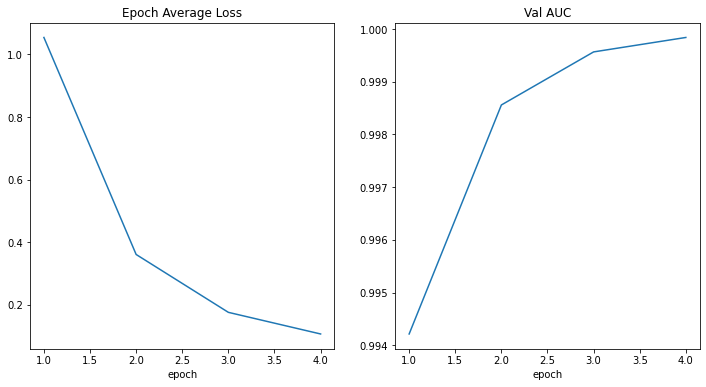

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

##  Evaluate your model and understand the results
### Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset. But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting. We'll use these predictions to generate a classification report.

In [19]:
net.load_state_dict(torch.load(os.path.join(root_dir, "mednist_model_best.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9883    0.9779    0.9831      1039
   BreastMRI     0.9923    0.9890    0.9906       910
         CXR     0.9949    0.9889    0.9919       987
     ChestCT     0.9866    1.0000    0.9933      1033
        Hand     0.9896    0.9835    0.9865       967
      HeadCT     0.9831    0.9943    0.9886      1050

    accuracy                         0.9890      5986
   macro avg     0.9891    0.9889    0.9890      5986
weighted avg     0.9890    0.9890    0.9890      5986



### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


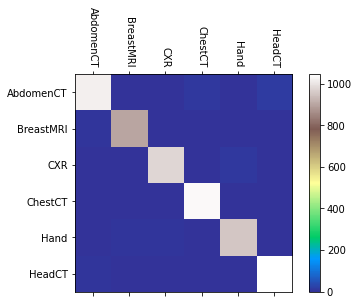

In [21]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02 ](./02_pipeline_02.ipynb)
- [02_pipeline_03 Next ](./02_pipeline_03.ipynb)
- [02_pipeline_04](./02_pipeline_04.ipynb)

- [03_brain_gan ](./03_brain_gan_01.ipynb)

- [04_spleen_segment](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>